## Use-case : Heat Exchanger Monitoring

When a heat exchanger has been in operation for a while, its performance decreases for a variety of reasons - such as, fouling, scaling, corrosion etc.
It’s important to monitor the heat transfer efficiency of the heat exchanger, in order to obtain the desired output.

We'll monitor the **thermal resistance** of a heat exchanger.
This is important for the maintenance and cleaning of the HE. If the thermal resistance goes down, it’s not performing at the optimal level so we need to start cleaning and/or maintenance.


There are some heat exchangers in the Open Industrial Dataset, we'll examine one of them here.

System is shown in the P&ID file here https://fusion.cognite.com/publicdata/explore/file/3136055771416774

As we see in the annotated P&ID diagrams, with the contextualization. Various sensor data or tags stored in the CDF can be accessed directly from the diagram.

<img src="../images/pnid-screenshot.png">

### Simplified System Diagram

Discharge coolers are 2-stage heat exchangers as shown in the Figure, along with the various sensors for inflow & outflow.

<img src="../images/simplified-system-diagram.png">

Next, we'll use the Cognite Data Fusion to retrieve these sensors data and ways to calculate the thermal resistance.

## Authentication and Client Creation for CDF

Here we'll create the cognite client using Client credentials. We need to supply the tenant_id, client_id and client secret along with cluster name and project name to create the cognite client. Once this client is created, this will be the main way to communicate with the Cognite Data Fusion.

Import and create a client to communicate with the cognite data platform (CDF)

In [1]:
#from cognite.client import CogniteClient
from cognite.experimental import CogniteClient

In [2]:
import os
from getpass import getpass
from pathlib import Path
from dotenv import load_dotenv
# Contact Project Administrator to get these
TENANT_ID="48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID="fab52bb5-9de2-4f9e-aefa-712da4b5fe00"
CDF_CLUSTER="westeurope-1"
COGNITE_PROJECT="ds-basics"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

# Obtain the Environment Variables from .env file
dotenv_path = Path("../.env")
load_dotenv(dotenv_path=dotenv_path)
CLIENT_SECRET = os.getenv("CLIENT_SECRET") 
#CLIENT_SECRET = getpass("Enter the Client Secret: ") # To pass secret interactively

TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"

client = CogniteClient(
    token_url=TOKEN_URL,
    token_client_id=CLIENT_ID,
    token_client_secret=CLIENT_SECRET,
    token_scopes=SCOPES,
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cdf_client",
    debug=False,
)

This is just one of the ways to create the client, there are many other ways e.g. Interactive login, Device code etc

Guide for authentication and creating the client is available here https://github.com/cognitedata/python-oidc-authentication

## Finding data related to the System

This can be achieved with the Hierarchy based structure in the CDF. High level System are stored as the Assets e.g. here **23-HA-9114** and **23-HA-9115** are stored as the assets. All the tags related to them are linked to the respective assets in order to access them easily.

Let's quickly get the IDs for assets we're interested in

In [3]:
asset_name = "23-HA-9114"
assets = client.assets.search(name=asset_name)
assets[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,source,id,created_time,last_updated_time,root_id
0,5345363121325760,23-HA-9114,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,7640884189698369,1652690345913,1652690345913,2075231145010555
1,1305599545806638,23-HA-9115,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 2,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,2096576847847256,1652690345913,1652690345913,2075231145010555
2,8820916275841408,23-VA-9114,6990494653502625,2499711953216311,VRD - 1ST STAGE COMPRESSOR MARINE VANE SEPARATOR,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,8140508315193333,1652690345913,1652690345913,2075231145010555
3,1308676097270399,23-GO-9114,6990494653502625,2499711953216311,VRD - 1ST STAGE COMPPRESSOR ENCLOSURE INLET AI...,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,7778925754685498,1652690345913,1652690345913,2075231145010555
4,2861239574637735,23-HA-9103,264396548249584,2513266419866445,VRD - 1ST STAGE SUCTION COOLER,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531306', ...",petro-tech-staging,7130743143880734,1652690345913,1652690345913,2075231145010555


Now we can use the first two IDs to get the time series or any other data related to these two Heat Exchangers/Discharge coolers **23-HA-9114** and **23-HA-9115**

In [4]:
client.time_series.list(asset_subtree_ids=[7640884189698369,2096576847847256])[:5]

,id,external_id,name,is_string,metadata,asset_id,is_step,description,security_categories,created_time,last_updated_time,unit
0,328127348154751,pi:160037,VAL_23_FIC_92543_08:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH 1stStgComp AntSrg Limit 2 PV,[],1652691565833,1652691565833,NaN
1,385469970857424,pi:191092,VAL_23-TT-92604A:X.Value,False,"{'engunits': 'degC', 'span': '100', 'instrumen...",7472153895477615,False,PH 1stStgDiscCool Gas Out Output,[],1652691565833,1652691565833,degC
2,524525133603395,pi:160039,VAL_23_FIC_92543_11:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH Surge Counter,[],1652691566033,1652691566033,NaN
3,963605533237469,pi:160888,VAL_23-TT-92603:X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",4307262662732694,False,PH 1stStgDiscCool Gas Out,[],1652691565806,1652691565806,NaN
4,1336520588941003,pi:160034,VAL_23_FIC_92543_05:Z.X.Value,False,"{'engunits': '', 'span': '100', 'instrumenttag...",5552983701089393,False,PH 1stStgComp First AntSrg CountTot,[],1652691566102,1652691566102,NaN


You can also retrieve the subtree for these Assets

In [5]:
subtree = client.assets.retrieve_subtree(id=7640884189698369)
subtree[:5]

,external_id,name,parent_id,parent_external_id,description,metadata,source,id,created_time,last_updated_time,root_id
0,5345363121325760,23-HA-9114,264396548249584,2513266419866445,VRD - 1ST STAGE DISCHARGE COOLER 1,"{'ELC_STATUS_ID': '1211', 'RES_ID': '531303', ...",petro-tech-staging,7640884189698369,1652690345913,1652690345913,2075231145010555
1,6045313781173559,23-FV-92543,7640884189698369,5345363121325760,VRD - PH 1STSTGCOMP ANTI-SURGE,"{'ELC_STATUS_ID': '1211', 'RES_ID': '569425', ...",petro-tech-staging,534249684184196,1652690345913,1652690345913,2075231145010555
2,3214951100107740,45-TT-92606,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCCLR COOLMED SPLY,"{'ELC_STATUS_ID': '1211', 'RES_ID': '496518', ...",petro-tech-staging,791972270586176,1652690345913,1652690345913,2075231145010555
3,5901066000673985,23-ESDV-92551B,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCHCLR GAS OUT EQ,"{'ELC_STATUS_ID': '1211', 'SOURCE_DB': 'workma...",petro-tech-staging,1427443677325668,1652690345913,1652690345913,2075231145010555
4,5412677358344403,23-TV-92604B,7640884189698369,5345363121325760,VRD - PH 1STSTGDISCCOOL COOLMED IN,"{'ELC_STATUS_ID': '1211', 'RES_ID': '609904', ...",petro-tech-staging,2179606378425112,1652690345913,1652690345913,2075231145010555


There are many filtering and searching options in python sdk. refer to the documentation for more details.

## Retrieve the Data

Let's Fetch the Temperatures and Flow rates for the discharge coolers

In [6]:
column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]

We can look up external IDs for the sensors we're interested in and use them to filter & retrieve the data we need from CDF.

In [7]:
ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']

Specify the start and end date , there are also options for aggregation and granularity of data.

Note : Instead of dates, we can also specify strings for start and end dates, e.g. **start="2w-ago", end="now"**

In [24]:
import datetime
from datetime import timedelta
start_date = datetime.datetime(2018, 8, 1)
end_date = start_date + timedelta(days=30)

df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                     aggregates=['average'],
                                                     granularity='1h',
                                                     start=start_date,
                                                     end=end_date,
                                                     include_aggregate_name=False
                                                     )
df.fillna(method="ffill", inplace=True)
df.columns = column_names
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,101.142261,164362.175208
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,99.901727,163875.622135
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,100.574942,164397.399993
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,99.346718,163128.807848
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,99.440407,163634.013288


## Visualize the data

Let's quickly plot the data

In [25]:
import matplotlib.pyplot as plt

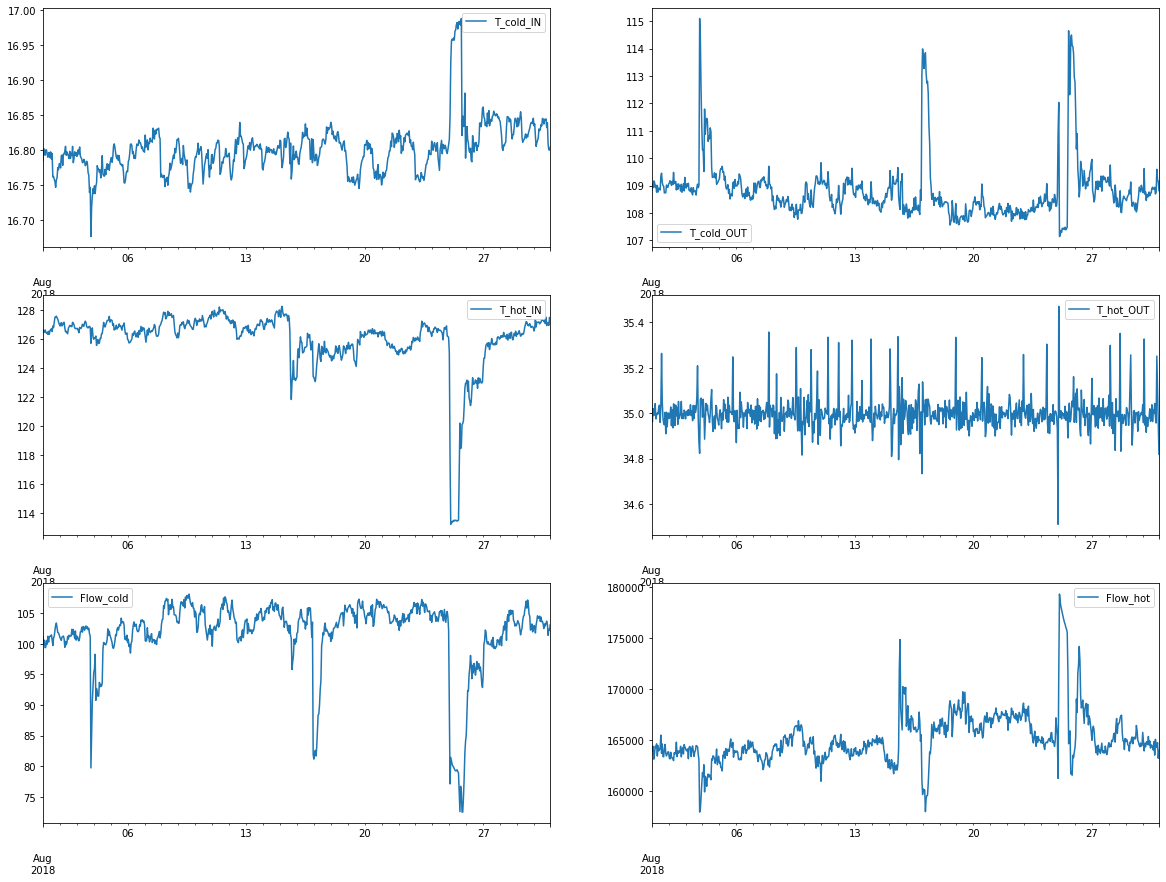

In [26]:
cols = df.columns

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,15))
for i, col in enumerate(cols):
    df.loc[:, [col]].plot(ax=axes.ravel()[i])

## Heat Exchanger Calculations

First of all let's bring the mass flow rates into same unit of measurement. (kg/seconds)

In [27]:
df['Flow_cold'] = df['Flow_cold']*1000/3600.0
df['Flow_hot'] = df['Flow_hot']/3600.0

In [28]:
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,28.095072,45.656160
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,27.750480,45.521006
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,27.937484,45.665944
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,27.596311,45.313558
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,27.622335,45.453893


Let's create the function for Thermal Resistance Calculation TR = A * F * LMTD/Q

where A=Area, F= Correction Factor, LMTD - Log Mean Temperature Difference,
Q - Heat Transfer Rate

LMTD = ((T_hot_IN-T_cold_OUT)-(T_hot_OUT-T_cold_IN))/(log((T_hot_IN-T_cold_OUT)/(T_hot_OUT-T_cold_IN)))

Q = Flow_hot * Cp_hot *(T_hot_IN-T_hot_OUT)

Let's implement these formulaes in a function

In [29]:
from math import log

In [30]:
def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = abs(x['T_hot_IN'] - x['T_cold_OUT'])
    x['dT2'] = abs(x['T_hot_OUT'] - x['T_cold_IN'])
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    TR = temp1/temp2
    return TR

In [31]:
df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)

In [32]:
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot,TR
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,28.095072,45.656160,0.001434
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,27.750480,45.521006,0.001424
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,27.937484,45.665944,0.001427
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,27.596311,45.313558,0.001431
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,27.622335,45.453893,0.001424


Now this calculation result is only available in this notebook, and each time  we need the value of Thermal Resitance, we'll have to fecth the data and run the above code manually. In the case, we want to presist the result of this calculation, we need to save this in CDF.

Cognite functions can be a solution for this type of calculation and saving results in CDF to be accessible later use or in other applications. 

## Cognite functions
There are multiple ways to create and deploy cognite functions, as shown in following sections:


## Method 1: Using Cognite Python SDK

As shown in the Examples https://github.com/cognitedata/cognite-function-examples/blob/main/examples/01-creating-a-function-from-a-notebook/create-cognite-function.ipynb , we need to create a function called "handle" and put the required calculation code/steps inside it.

In [37]:
def handle(client, data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=10)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='6h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Return the result as json
    result = df[['TR']].to_json()
    return result

#### Testing the function locally
Before we deploy this Python-function as a Cognite Function, we can verify that it works locally by passing in our previously instantiated CogniteClient and a data-dictionary.



In [38]:
handle(client)

'{"TR":{"1533081600000":0.0000003966,"1533103200000":0.0000003973,"1533124800000":0.0000003986,"1533146400000":0.000000404,"1533168000000":0.0000004002,"1533189600000":0.0000003968,"1533211200000":0.0000003998,"1533232800000":0.0000003995,"1533254400000":0.0000003981,"1533276000000":0.0000004014,"1533297600000":0.0000004022,"1533319200000":0.0000003718,"1533340800000":0.0000003796,"1533362400000":0.0000003757,"1533384000000":0.0000003942,"1533405600000":0.0000004016,"1533427200000":0.0000003976,"1533448800000":0.000000398,"1533470400000":0.0000004012,"1533492000000":0.0000003983,"1533513600000":0.0000003908,"1533535200000":0.0000003976,"1533556800000":0.0000003976,"1533578400000":0.0000004013,"1533600000000":0.0000003962,"1533621600000":0.0000003976,"1533643200000":0.0000003979,"1533664800000":0.0000003988,"1533686400000":0.0000004085,"1533708000000":0.0000004102,"1533729600000":0.0000004098,"1533751200000":0.0000003997,"1533772800000":0.0000004035,"1533794400000":0.0000004058,"1533816

#### Deploying function to CDF

If the calculation is simple and basic, doesn't need any external dependencies, it can be created & deployed directly using python-sdk, by passing handle function as a parameter ( for function_handle) in functions.create command, as shown below.

In [19]:
function_external_id = "hx_thermal_perf"
function_name = "Thermal Performance Calculation"

In [23]:
# Delete If the same function exists already
# client.functions.delete(external_id=function_external_id)

In [24]:
function = client.functions.create(
    name=function_name,
    external_id=function_external_id,
    function_handle=handle,
    description="Function to Calculate Thermal Performance of Discharge Coolers",
    runtime="py39")

##### Checking the Status of Deployment
This might take few minutes, before function is ready to run.

In [25]:
# Repeat until status is ready
while function.status != "Ready":
    function.update()

    if function.status == "Failed":
        print("Failed to deploy function")
        break
else:
    print("Function is successfully deployed")

Function is successfully deployed


##### Calling the deployed function

In [26]:
call = function.call()
call

,value
id,1923092584087690
start_time,1658835059879
end_time,1658835064409
status,Failed
function_id,8002266153092455


In [27]:
call.get_response()

In [28]:
call.get_logs()

,timestamp,message
0,1658835063914,Traceback (most recent call last):
1,1658835063914,"File ""/home/site/wwwroot/.python_packages/li..."
2,1658835063914,return importlib.import_module(name)
3,1658835063914,"File ""/usr/local/lib/python3.9/importlib/__i..."
4,1658835063914,return _bootstrap._gcd_import(name[level:]...
5,1658835063914,"File ""<frozen importlib._bootstrap>"", line 1..."
6,1658835063914,"File ""<frozen importlib._bootstrap>"", line 1..."
7,1658835063914,"File ""<frozen importlib._bootstrap>"", line 9..."
8,1658835063914,ModuleNotFoundError: No module named 'pandas'
9,1658835063914,NaN


As logs say "ModuleNotFoundError: No module named 'pandas'" , we need to fix the missing packages issue. Since our function isn't a basic one, it needs pandas package & cognite-sdk.

#### Adding Missing Packages in the function

If our function needs additional packages, We have to create the function using a folder containing handler.py and requirements.txt file.

Create a folder called "hx-thermal-resistance"

In [29]:
# Already created and added in the repository, so this command not required to run
# ! mkdir ../hx-thermal-resistance

In [30]:
# First let's delete the function as we'll re-create it
client.functions.delete(external_id=function_external_id)

Create a file "handler.py" and in this file put all the code shown in below cell ( which is the complete code for the function we need to create )

In [31]:
from math import log
import datetime
from datetime import timedelta

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    TR = temp1/temp2
    return TR


def handle(client,data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=10)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='6h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Return the result as json
    result = df[['TR']].to_json()
    return result

After that create a file "requirements.txt" and put the required packages and their versions in this file. e.g. cognite-sdk, pandas etc

#### Create Cognite Function from a Folder

In [32]:
function = client.functions.create(
    name=function_name,
    external_id=function_external_id,
    folder="../hx-thermal-resistance/",  # We will upload this directory
    description="Function to Calculate Thermal Performance of Discharge Coolers",
    owner="Choukha Ram",
)

Check the status and make a call to the function

In [33]:
# Repeat until status is ready
while function.status != "Ready":
    function.update()

    if function.status == "Failed":
        print("Failed to deploy function")
        break
else:
    print("Function is successfully deployed")

Function is successfully deployed


In [34]:
call = function.call()
call

,value
id,2162238284988694
start_time,1658835672147
end_time,1658835682265
status,Completed
function_id,5143717420027456


In [35]:
call.get_response()

'{"TR":{"1652788800000":0.0000003761,"1652792400000":0.0000003655,"1652796000000":0.0000003652,"1652799600000":0.0000003719,"1652803200000":0.0000003629,"1652806800000":0.0000003615,"1652810400000":0.0000003595,"1652814000000":0.0000003556,"1652817600000":0.00000036,"1652821200000":0.0000003571,"1652824800000":0.0000003541,"1652828400000":0.0000003558,"1652832000000":0.0000003533,"1652835600000":0.0000003538,"1652839200000":0.0000003528,"1652842800000":0.0000003525,"1652846400000":0.0000003545,"1652850000000":0.0000003532,"1652853600000":0.0000003599,"1652857200000":0.0000003687,"1652860800000":0.0000003778,"1652864400000":0.0000003752,"1652868000000":0.0000003843,"1652871600000":0.0000003841}}'

## Method 2: Using Cognite Data Fusion UI
Download & Zip the handler.py and requirements.txt files and upload the zipped file in the CDF UI. (https://cognite-learn.fusion.cognite.com/ds-basics/functions?cluster=westeurope-1.cognitedata.com&env=westeurope-1)

<img src="../images/cognite-functions-via-UI.jpg">

### Save the calculation result using Cognite Functions

In the cognite functions, we can also persist the result into a time series or other resource type suitable for the result.
Let's add some extra lines of code to save the calculated values in a time series.

In [ ]:
from cognite.client.data_classes import TimeSeries
from math import log
import datetime
from datetime import timedelta

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    Cp_cold	= 4.18
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    tr = temp1/temp2
    return tr

def create_and_save_time_series_data(client,data):
  '''Function to create the time series and save the data'''
  asset_id = 7640884189698369 # 23-HA-9114 Asset
  ts_external_id = "hx_thermal_resistance"
  cdf_ts = client.time_series.retrieve(external_id=ts_external_id)
  if cdf_ts is None:
    ts = TimeSeries(external_id=ts_external_id,name="Thermal Resistance", asset_id = asset_id, unit = 'm2K/W')
    client.time_series.create(ts)
    print("Created time series")
  else:
    print("Existing Time Series")
  dps = []
  for index, r in data.iterrows():
      dps= dps+[{"timestamp": r.name, "value": r['TR']}]
  try:
      client.datapoints.insert(datapoints = dps,external_id = ts_external_id)
  except:
      pass



def handle(client, data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=30)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='1h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Save the Result as time series
    create_and_save_time_series_data(client,df[['TR']])
    # Return the result as json
    result = df[['TR']].to_json()
    return result

Update the handler.py file with the above code and deploy the function again to see the persisted result in a time series.

We can create a new folder for this function & put the updated handler.py file and requirements.txt in it.

In [42]:
#! mkdir ../hx-thermal-resistance-save-calc 

In [3]:
function = client.functions.create(
    name="Thermal Performance Calculation and Save Function",
    external_id="thermal-perf-save-calc",
    folder="../hx-thermal-resistance-save-calc/",
    description="Function to Calculate & Save Thermal Performance of Discharge Coolers",
    owner="Choukha Ram"
    )
# Note : if this cell is giving you errors :
# Just restart the notebook, create the cognite client and run this cell again.

Go to the CDF UI to see when function is ready, call it using code or UI to find the output saved in a timeseries in CDF.

## Machine Learning to Forecast the thermal resistance

Along with the Physics calculations, if we need to predict the values of thermal resistance for future timesteps, based on trend or other factors, we can quickly build a model which will forecast the thermal resistance, based on recent history and it can be used to monitor the Performance of the Heat exchanger and using predictions, we can detect any upcoming issues or problems in the system.

First install the library we'll use for forecasting

In [4]:
%pip install -q Prophet

Note: you may need to restart the kernel to use updated packages.


Now, let's format the data suitable for Prophet functions

In [17]:
df2 = df.copy()[['TR']].reset_index()
df2 = df2.rename(columns={'index':"ds",'TR':"y"})

df2.head()

,ds,y
0,2022-05-17 14:00:00,0.001315
1,2022-05-17 15:00:00,0.001339
2,2022-05-17 16:00:00,0.001307
3,2022-05-17 17:00:00,0.001301
4,2022-05-17 18:00:00,0.001294


In [18]:
df.shape

(22, 7)

In [19]:
from prophet import Prophet

/home/cram/dev/learn-cognite-functions/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [20]:
m = Prophet()
m.fit(df2)

15:03:13 - cmdstanpy - INFO - Chain [1] start processing
15:03:13 - cmdstanpy - INFO - Chain [1] done processing


### Forecast for next 15 days

Let's add 10% increase from the historical mean as the threshold for monitoring

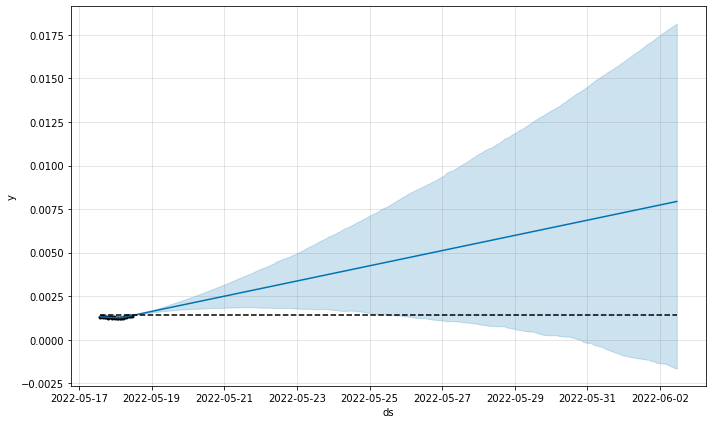

In [23]:
future = m.make_future_dataframe(periods=24*15, freq='H')
future['cap'] = 1.1*df['TR'].mean() #
fcst = m.predict(future)
fig = m.plot(fcst)

It shows that as per current trend based on last few weeks, data, it will cross the threshold very soon. This information can be utilized by the maintenance department or the operations.

Next, we can create the cognite function to run this model daily and save the forecasts in CDF for monitoring purposes.

## Running ML predictions with cognite functions

Add the below code the the handler.py file. Additionally, we need to create a requirements.txt file to add the Prophet library as dependency to be installed.

In [39]:
from cognite.client.data_classes import TimeSeries
from math import log
import datetime
from datetime import timedelta
from prophet import Prophet

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    tr = temp1/temp2
    return tr

def thermal_resistance_forecast(df):
    '''Function to forecast the Thermal Resistance'''
    df2 = df.copy()[['TR']].reset_index()
    df2 = df2.rename(columns={'index':"ds",'TR':"y"})
    m = Prophet()
    m.fit(df2)
    future = m.make_future_dataframe(periods=24*15, freq='H')
    future['cap'] = 1.1*df['TR'].mean() #
    fcst = m.predict(future)
    fcst_df = fcst[['ds','yhat']].set_index('ds')
    fcst_df.columns = ['TR']
    return fcst_df

def create_and_save_time_series_data(client,data,ts_external_id):
  '''Function to create the time series and save the data'''
  asset_id = 7640884189698369 # 23-HA-9114 Asset
  cdf_ts = client.time_series.retrieve(external_id=ts_external_id)
  if cdf_ts is None:
    ts = TimeSeries(external_id=ts_external_id,name=ts_external_id, asset_id = asset_id, unit = 'm2K/W')
    client.time_series.create(ts)
    print("Created time series")
  else:
    print("Existing Time Series")
  dps = []
  for index, r in data.iterrows():
      dps= dps+[{"timestamp": r.name, "value": r['TR']}]
  try:
      client.datapoints.insert(datapoints = dps,external_id = ts_external_id)
  except:
      pass


def handle(client,data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=30)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='1h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Forecast the Thermal resistance
    fcst_df = thermal_resistance_forecast(df)
    # Save the Results as time series
    create_and_save_time_series_data(client,df[['TR']],"hx_thermal_resistance")
    create_and_save_time_series_data(client,fcst_df[['TR']],"hx_thermal_resistance_forecast")
    # Return the result as json
    result = df[['TR']].to_json()
    return result

We can create a new folder and save the updated handler.py & requirements.txt file there.

In [ ]:
# ! mkdir ../hx-thermal-resistance-forecast

In [40]:
function = client.functions.create(
    name="Thermal Performance Forecasting Function",
    external_id="thermal-perf-forecast",
    folder="../hx-thermal-resistance-forecast/",
    description="Function to Calculate & Forecast Thermal Performance of Discharge Coolers",
    owner="Choukha Ram"
    )
# Note : if this cell is giving you errors :
# Just restart the notebook, create the cognite client and run this cell again.

### Running calculations on a Schedule

When creating function in CDF UI, we can also create the schedule,
- for hourly schedule, enter this cron expression `0 * * * *`
- for daily `0 0 * * *` 
- for every minute `* * * * *` 

<img src="../images/create_schedule_ui.jpg">

You can also create the Schedule using the Python SDK, for which you'll need the client credentials.

In [41]:
client_credentials = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
}
schedule = client.functions.schedules.create(
    name="run-function-every-day",
    cron_expression="0 0 * * *",  # the cron expression runs every day
    function_id=function.id,  # we specify the ID of the function we want to schedule
    client_credentials=client_credentials,  # this is a dictionary with 'client_secret' and 'client_id'
    data={},  # this is the data we wish to call the function with (e.g. time range for calculation)
    description="This schedule runs the function every minute",
)

Use the code or UI to make a call to the function and verify the output in CDF or response from function. Check the logs if any issues.

#### Access the Function Calls

List the calls made to the function

In [44]:
calls = function.list_calls()
calls

,id,start_time,status,function_id,end_time
0,3845225630074099,1658843665482,Running,6329621345240516,<NA>
1,1008723032366312,1658843514201,Completed,6329621345240516,1658843549280


Get the response from the latest call

In [ ]:
# Get the response of the last function call
calls[-1].get_response()

## Method 3: Using Deploy functions Template

When you've tested you functions locally and want to deploy multiple functions related to a project, using version control (CI/CD). There's a public template which can be used to deploy the functions.

- Follow the instructions given in the template documentation. https://github.com/cognitedata/deploy-functions-oidc#how-to-use-it

- Create a separate folder for each function and place the code files e.g. handler.py and requirements.txt files inside it.

## Visualization in the PowerBI/Grafana
Once calculation results are stored in the CDF, they can be fed to downstream visualization applications such as PowerBI or Grafana.
An example grafana dashboard for the Heat Exchanger case is shown here.

URL (restricted access ) https://grafana-tech-sales.cogniteapp.com/d/EgxLOhE7x/heatex-demo?orgId=1

<img src="../images/grafana-hx-monitor.jpg">

## Cleanup

You can delete the created/deployed function using Code or UI. This will also delete the schedules along with them.

In [ ]:
client.functions.delete(id=function.id)